# EP1 - Conjunto de Maldelbrot e paralelização com pThreads e OpenMP

| Nome | NUSP |
|------|------|
| Giulia C. de Nardi | 10692203 |
| Vitor D. Tamae | 10705620 |
| Lucy Anne de Omena Evangelista | 11221776 |
| Leonardo Costa Santos | 10783142 |
| Alexandre Muller Jones | 8038149 |


Caso não queira rodar novamente os experimentos, por favor pular para a sessão "Gráficos comparativos".

## Configuração do ambiente

Atualizando os pacotes Julia

In [1]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % [=========>                               ]  22.0 %Fetching: [=============>                           ]  31.8 %                  ]  53.6 %===============================>         ]  75.6 %Fetching: [=======================================> ]  97.3 % Resolving package versions...
 Installed FiniteDiff ─────── v2.3.2
 Installed DataStructures ─── v0.17.17
 Installed Colors ─────────── v0.12.1
 Installed SpecialFunctions ─ v0.10.3
 Installed FillArrays ─────── v0.8.10
 Installed DataFrames ─────── v0.21.1
  Updating `~/.julia/environments/v1.3/Project.toml`
  [a93c6f00] ↑ DataFrames v0.21.0 ⇒ v0.21.1
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [5ae59095] ↑ Colors v0.12.0 ⇒ v0.12.1
  [a93c6f00] ↑ DataFrames v0.21.0 ⇒ v0.21.1
  [864edb3b] ↑ DataStructures v0.17.16 ⇒ v0.17.17
  [1a297f60] ↑ Fi

Verificando o status dos pacotes, e se há algum problema, com o comando:

In [3]:
] st

    Status `~/.julia/environments/v1.3/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.1
  [31c24e10] Distributions v0.23.2
  [7073ff75] IJulia v1.21.2
  [b964fa9f] LaTeXStrings v1.1.0
  [8314cec4] PGFPlotsX v1.2.6
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6
  [10745b16] Statistics 


Chamando pacotes que usaremos:

In [4]:
using DataFrames, Query, StatsPlots, Statistics

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273
┌ Info: Precompiling Query [1a8c2f83-1ff3-5112-b086-8aa67b057ba1]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


## Funções para realização dos experimentos

In [56]:
; make mandelbrot_seq

make: 'mandelbrot_seq' is up to date.


In [57]:
; ./mandelbrot_seq

usage: ./mandelbrot_seq c_x_min c_x_max c_y_min c_y_max image_size
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_seq -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_seq 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_seq -0.188 -0.012 0.554 0.754 11500


In [58]:
; ./mandelbrot_seq 0.175 0.375 -0.1 0.1 200 0

0.047196,0.049695


A função abaixo recebe parâmetros `size`, com o tamanho da imagem, `f`, com a id do tupo de fractal a ser feito (0 - Full, 2 - Triple Spiral, 3 - Elephant, 4 - Seahorse), `mandel`, com o nome da função a ser executada (`./mandelbrot_seq`, `./mandelbrot_opm`, `./mandelbrot_pth`),e `threads`, com o número de threads do programa paralelo. A função executa o programa `mandelbrot` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [5]:
function measure_mandelbrot(size, f, mandel; thread = 0)    
    if f == 0  mode = `-2.5 1.5 -2.0 2.0` #full
    elseif f == 1  mode = `-0.188 -0.012 0.554 0.754` #triple spiral
    elseif f == 2  mode = `0.175 0.375 -0.1 0.1` # elephant
    elseif f == 3  mode = `-0.8 -0.7 0.05 0.15` #seahorse
    end
    
    if thread != 0 
    results = parse.(Float64,
        split(chomp(read(`./$mandel $mode $size $thread `, String)), ","))
    else
    results = parse.(Float64,
        split(chomp(read(`./$mandel $mode $size`, String)), ","))
    end
    
    return DataFrame(size = size,
        f = f,
        threads = thread,
        duration = results[1],
        io_alocation = results[2])
end

measure_mandelbrot (generic function with 1 method)

A função `run_experiments` recebe os mesmos parâmetros `size`, `f`,`mandel` e `threads`, e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento com um dado número de `threads`. A função devolve um `DataFrame` com todos os experimentos.

In [6]:
function run_experiments(size, f, mandel, repetitions; threads = [])
    run(`make $mandel`)
        
    results = DataFrame(size = Int[],
        f = Int[],
        threads = Int[],
        duration = Float64[],
        io_alocation = Float64[]) 
    
    if threads != []
    
        for t in threads
            for s in size
                for r in 1:repetitions
                append!(results,
                    measure_mandelbrot(s, f, mandel, thread = t))    
                end
            end
        end
        
    else
    
        for r in 1:repetitions
            for s in size
                append!(results,
                    measure_mandelbrot(s, f, mandel))    
            end
        end
    
    end
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% dos tempos de execução, agrupados por número de threads.

In [7]:
function parse_results(results)
    parsed_results = results |>
                    @groupby({_.threads,_.size}) |>
                    @map({threads = key(_).threads,
                          size = _.size[1],
                          mean_duration = mean(_.duration),
                          mean_io_alocation = mean(_.io_alocation),
                          ci_duration = 1.96 * std(_.duration),
                          ci_io_alocation = 1.96 * std(_.io_alocation)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results (generic function with 1 method)

## Funções para traçar gráficos

A função abaixo permite que sejam traçadas até 5 séries de dados em um mesmo gráfico do tipo scatter.

In [72]:
pgfplotsx()

function plot_results(x, y, series_label, yerror; x2 = x, y2 = [], series_label2 = [], yerror2 = [], 
        x3 = x, y3 = [], series_label3 = [], yerror3 = [], x4 = x, y4 = [], series_label4 = [], yerror4 = [],
        x5 = x, y5 = [], series_label5 = [], yerror5 = [], title = "", xaxis = "Threads",max_thread_power = 5)
    
    
    p = scatter(x, y, xaxis = :log2, xlabel = xaxis, xticks = [2 ^ x for x in 0:max_thread_power],
        yerror = yerror, alpha = 0.6, 
        labels = series_label, legend = :best, title = title)
    
    if y2 != []
        p = scatter!(x2, y2, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror2, alpha = 0.6,
            labels = series_label2, legend = :best)
    end
    if y3 != []
        p = scatter!(x3, y3, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror3, alpha = 0.6,
            labels = series_label3, legend = :best)
    end
    if y4 != []
        p = scatter!(x4, y4, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror4, alpha = 0.6,
            labels = series_label4, legend = :best)
    end
    if y5 != []
        p = scatter!(x5, y5, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror5, alpha = 0.6,
            labels = series_label5, legend = :best)
    end
    
    return p
end

plot_results (generic function with 1 method)

## Condições para os experimentos

In [71]:
size = [2 ^ x for x in 4:13]
thread = [2 ^ x for x in 0:5]
repetitions = 10;
#size = [2 ^ x for x in 4:7]
#thread = [2 ^ x for x in 0:3]
#repetitions = 2;

# Gerando e Salvando dados

## Mandelbrot sequencial

Nesta parte, traremos a execução do maldelbrot em sua versão sequencial, junto com a análise de tempo de execução para os diferentes tipo de fractais (Triple Spiral, Elephant, Seahorse & Full) e em diferentes resoluções ($ 2^4 \cdots 2^{13}$)

Realizando as medições para o mandelbrot sequencial:

In [72]:
results_seq_full = run_experiments(size, 0, "mandelbrot_seq", repetitions)
seq_full = parse_results(results_seq_full);

make: 'mandelbrot_seq' is up to date.


In [67]:
seq_full

,threads,size,mean_duration,mean_io_alocation,ci_duration,ci_io_alocation
,Int64,Int64,Float64,Float64,Float64,Float64
1,0,16,8.65e-5,0.000188,8.17698e-5,0.000205118
2,0,32,0.000258,0.0004065,0.000196802,0.000347868
3,0,64,0.000992,0.0012815,0.000770577,0.00106855
4,0,128,0.003373,0.0041175,0.00104499,0.00104083


In [73]:
results_seq_triplespiral = run_experiments(size, 1, "mandelbrot_seq", repetitions)
seq_triplespiral = parse_results(results_seq_triplespiral);

make: 'mandelbrot_seq' is up to date.


In [74]:
results_seq_elephant = run_experiments(size, 2, "mandelbrot_seq", repetitions)
seq_elephant = parse_results(results_seq_elephant);

make: 'mandelbrot_seq' is up to date.


ProcessFailedException: failed process: Process(`./mandelbrot_seq 0.175 0.375 -0.1 0.1 8192`, ProcessSignaled(2)) [0]


In [75]:
results_seq_seahorse = run_experiments(size, 3, "mandelbrot_seq", repetitions)
seq_seahorse = parse_results(results_seq_seahorse);

make: 'mandelbrot_seq' is up to date.


InterruptException: InterruptException:

In [ ]:
showall(seq_seahorse)

## Mandelbrot com pthreads

In [24]:
results_pth_full = run_experiments(size, 0, "mandelbrot_pth", repetitions,threads=thread)
pth_full = parse_results(results_pth_full);

make: 'mandelbrot_pth' is up to date.


In [25]:
pth_full

,threads,size,mean_duration,mean_io_alocation,ci_duration,ci_io_alocation
,Int64,Int64,Float64,Float64,Float64,Float64
1,1,16,0.0002328,0.0003282,4.98489e-5,4.84684e-5
2,1,32,0.000477,0.0006425,7.03843e-5,9.10844e-5
3,1,64,0.00152,0.001843,0.000203408,0.000230404
4,1,128,0.0056281,0.0068485,0.000907424,0.00128988
5,1,256,0.0208044,0.0247506,0.000763439,0.00082257
6,1,512,0.0817333,0.0972632,0.00501587,0.00515828
7,1,1024,0.321744,0.386844,0.00513979,0.0124842
8,1,2048,1.28677,1.54528,0.0228244,0.0349549
9,1,4096,5.13044,6.15101,0.0608508,0.0786069


In [26]:
results_pth_triplespiral = run_experiments(size, 1, "mandelbrot_pth", repetitions,threads=thread)
pth_triplespiral = parse_results(results_pth_triplespiral);

make: 'mandelbrot_pth' is up to date.


In [47]:
#showall(results_pth_triplespiral)

In [27]:
results_pth_elephant = run_experiments(size, 2, "mandelbrot_pth", repetitions,threads=thread)
pth_elephant = parse_results(results_pth_elephant);

make: 'mandelbrot_pth' is up to date.


In [50]:
results_pth_seahorse = run_experiments(size, 3, "mandelbrot_pth", repetitions,threads=thread)
pth_seahorse = parse_results(results_pth_seahorse);

make: 'mandelbrot_pth' is up to date.


## Mandelbrot com OpenMP

In [36]:
results_omp_full = run_experiments(size, 0, "mandelbrot_omp", repetitions,threads=thread)
omp_full = parse_results(results_omp_full);

make: 'mandelbrot_omp' is up to date.


ProcessFailedException: failed process: Process(`./mandelbrot_omp -2.5 1.5 -2.0 2.0 1024 1`, ProcessSignaled(2)) [0]


In [37]:
results_omp_triplespiral = run_experiments(size, 1, "mandelbrot_omp", repetitions,threads=thread)
omp_triplespiral = parse_results(results_omp_triplespiral);

make: 'mandelbrot_omp' is up to date.


InterruptException: InterruptException:

In [38]:
results_omp_elephant = run_experiments(size, 2, "mandelbrot_omp", repetitions,threads=thread)
omp_elephant = parse_results(results_omp_elephant);

make: 'mandelbrot_omp' is up to date.


InterruptException: InterruptException:

In [39]:
results_omp_seahorse = run_experiments(size, 3, "mandelbrot_omp", repetitions,threads=thread)
omp_seahorse = parse_results(results_omp_seahorse);

make: 'mandelbrot_omp' is up to date.


InterruptException: InterruptException:

In [40]:
showall(omp_seahorse)

UndefVarError: UndefVarError: omp_seahorse not defined

## Salvando dados

In [9]:
using CSV

function save_csv_results(results,filename)
    println(filename)
    CSV.write(filename, results)
end
using CSV

function read_csv_results(filename)
    results=CSV.read(filename)
    return results
end


┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273


read_csv_results (generic function with 1 method)

In [77]:
save_csv_results(results_seq_full,"results_data/seq_full.csv")
save_csv_results(results_seq_triplespiral,"data/results_seq_triplespiral.csv")
#save_csv_results(results_seq_elephant,"data/results_seq_elephant.csv")
#save_csv_results(results_seq_seahorse,"data/results_seq_seahorse.csv");
save_csv_results(seq_full,"data/seq_full.csv")
save_csv_results(seq_triplespiral,"data/seq_triplespiral.csv")
#save_csv_results(seq_elephant,"data/seq_elephant.csv")
#save_csv_results(seq_seahorse,"data/seq_seahorse.csv");

results_data/seq_full.csv


SystemError: SystemError: opening file "results_data/seq_full.csv": No such file or directory

In [41]:
save_csv_results(results_omp_full,"data/results_omp_full.csv")
save_csv_results(results_omp_triplespiral,"data/results_omp_triplespiral.csv")
save_csv_results(results_omp_elephant,"data/results_omp_elephant.csv")
save_csv_results(results_omp_seahorse,"data/results_omp_seahorse.csv");
save_csv_results(omp_full,"data/omp_full.csv")
save_csv_results(omp_triplespiral,"data/omp_triplespiral.csv")
save_csv_results(omp_elephant,"data/omp_elephant.csv")
save_csv_results(omp_seahorse,"data/omp_seahorse.csv");

UndefVarError: UndefVarError: results_omp_full not defined

In [51]:
save_csv_results(results_pth_full,"data/results_pth_full.csv")
save_csv_results(results_pth_triplespiral,"data/results_pth_triplespiral.csv")
save_csv_results(results_pth_elephant,"data/results_pth_elephant.csv")
save_csv_results(results_pth_seahorse,"data/results_pth_seahorse.csv")
save_csv_results(pth_full,"data/pth_full.csv")
save_csv_results(pth_triplespiral,"data/pth_triplespiral.csv")
save_csv_results(pth_elephant,"data/pth_elephant.csv")
save_csv_results(pth_seahorse,"data/pth_seahorse.csv");

data/results_pth_full.csv
data/results_pth_triplespiral.csv
data/results_pth_elephant.csv
data/results_pth_seahorse.csv
data/pth_full.csv
data/pth_triplespiral.csv
data/pth_elephant.csv
data/pth_seahorse.csv


# Gráficos comparativos

Ao final, teremos os dataframes:

|Dataframe | Full | Triple Spiral | Seahorse |
|----------|--------|--------|--------|
|Sequencial|seq_full|seq_triplespiral|seq_seahorse|
|PThreads|pth_full|pth_triplespiral|pth_seahorse|
|OpenMP|omp_full|omp_triplespiral|omp_seahorse|

Carregando os dataframes gerados, para testes futuros:

In [10]:
seq_full=read_csv_results("data/seq_full.csv")
seq_triplespiral=read_csv_results("data/seq_triplespiral.csv")
seq_elephant=read_csv_results("data/seq_elephant.csv")
seq_seahorse=read_csv_results("data/seq_seahorse.csv")
omp_full=read_csv_results("data/omp_full.csv")
omp_triplespiral=read_csv_results("data/omp_triplespiral.csv")
omp_elephant=read_csv_results("data/omp_elephant.csv")
omp_seahorse=read_csv_results("data/omp_seahorse.csv")
pth_full=read_csv_results("data/pth_full.csv")
pth_triplespiral=read_csv_results("data/pth_triplespiral.csv")
pth_elephant=read_csv_results("data/pth_elephant.csv")
pth_seahorse=read_csv_results("data/pth_seahorse.csv");

In [19]:
omp_full

,threads,size,mean_duration,mean_io_alocation,ci_duration,ci_io_alocation
,Int64,Int64,Float64,Float64,Float64,Float64
1,1,16,0.0001083,0.0001437,2.92909e-6,5.23075e-6
2,1,32,0.0003864,0.0004667,3.46353e-5,3.63414e-5
3,1,64,0.0014986,0.0017871,0.000208423,0.000254163
4,1,128,0.0058428,0.0069666,0.000538995,0.000929846
5,1,256,0.0232986,0.0275664,0.00197283,0.00220342
6,1,512,0.0909192,0.107433,0.00250957,0.00290357
7,1,1024,0.363441,0.430689,0.00783772,0.00989834
8,1,2048,1.44842,1.7222,0.021525,0.032073
9,1,4096,5.75735,6.82819,0.15229,0.216584


In [11]:
results_seq_full=read_csv_results("data/results_seq_full.csv")
results_seq_triplespiral=read_csv_results("data/results_seq_triplespiral.csv")
results_seq_elephant=read_csv_results("data/results_seq_elephant.csv")
results_seq_seahorse=read_csv_results("data/results_seq_seahorse.csv")
results_omp_full=read_csv_results("data/results_omp_full.csv")
results_omp_triplespiral=read_csv_results("data/results_omp_triplespiral.csv")
results_omp_elephant=read_csv_results("data/results_omp_elephant.csv")
results_omp_seahorse=read_csv_results("data/results_omp_seahorse.csv")
results_pth_full=read_csv_results("data/results_pth_full.csv")
results_pth_triplespiral=read_csv_results("data/results_pth_triplespiral.csv")
results_pth_elephant=read_csv_results("data/results_pth_elephant.csv")
results_pth_seahorse=read_csv_results("data/results_pth_seahorse.csv");

Realizaremos os gráficos a partir de partições do dataframe, como mostrados abaixo:

In [ ]:
filter(row -> row[:threads] == 1, omp_full)

In [ ]:
filter(row -> row[:size] == 16, omp_full)

In [ ]:
filter(row -> row[:size] == 16, omp_full).mean_duration

## Comparando desempenho por região

### Por quantidade de Threads

#### OpenMP

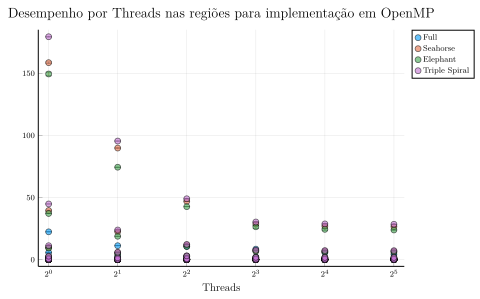

In [48]:
plot_results( omp_full.threads, omp_full.mean_duration, "Full", omp_full.ci_duration,
    y2 = omp_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = omp_seahorse.ci_duration,
    y3 = omp_elephant.mean_duration, series_label3 = "Elephant", yerror3 = omp_elephant.ci_duration,
    y4 = omp_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = omp_triplespiral.ci_duration,
    title = "Desempenho por Threads nas regiões para implementação em OpenMP")

#### PThreads

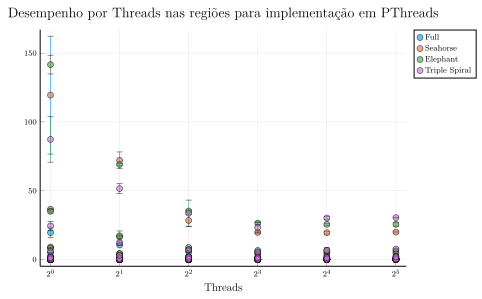

In [49]:
plot_results(pth_full.threads, pth_full.mean_duration, "Full", pth_full.ci_duration,
    y2 = pth_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = pth_seahorse.ci_duration,
    y3 = pth_elephant.mean_duration, series_label3 = "Elephant", yerror3 = pth_elephant.ci_duration,
    y4 = pth_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = pth_triplespiral.ci_duration,
    title = "Desempenho por Threads nas regiões para implementação em PThreads")

### Por tamanho da imagem

#### Sequencial

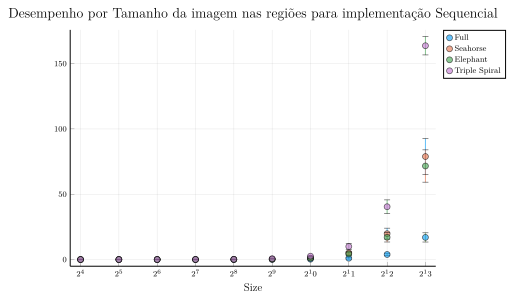

In [70]:
plot_results(seq_full.size, seq_full.mean_duration, "Full", seq_full.ci_duration,
    y2 = seq_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = seq_seahorse.ci_duration,
    y3 = seq_elephant.mean_duration, series_label3 = "Elephant", yerror3 = seq_elephant.ci_duration,
    y4 = seq_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = seq_triplespiral.ci_duration,
    title = "Desempenho por Tamanho da imagem nas regiões para implementação Sequencial",
    xaxis = "Size", max_thread_power = 13)

#### OpenMP

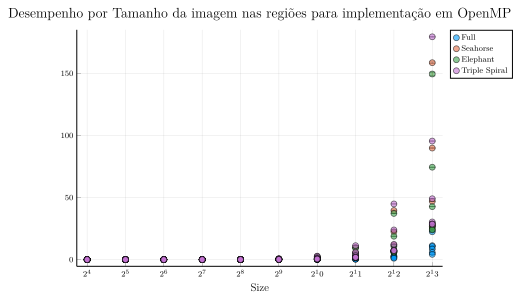

In [73]:
plot_results( omp_full.size, omp_full.mean_duration, "Full", omp_full.ci_duration,
    y2 = omp_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = omp_seahorse.ci_duration,
    y3 = omp_elephant.mean_duration, series_label3 = "Elephant", yerror3 = omp_elephant.ci_duration,
    y4 = omp_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = omp_triplespiral.ci_duration,
    title = "Desempenho por Tamanho da imagem nas regiões para implementação em OpenMP",
    xaxis = "Size", max_thread_power = 13)

#### PThreads

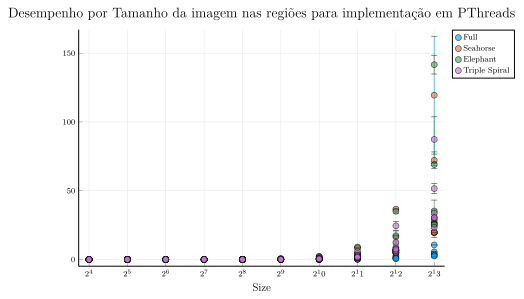

In [74]:
plot_results(pth_full.size, pth_full.mean_duration, "Full", pth_full.ci_duration,
    y2 = pth_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = pth_seahorse.ci_duration,
    y3 = pth_elephant.mean_duration, series_label3 = "Elephant", yerror3 = pth_elephant.ci_duration,
    y4 = pth_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = pth_triplespiral.ci_duration,
    title = "Desempenho por Tamanho da imagem nas regiões para implementação em PThreads",
    xaxis = "Size", max_thread_power = 13)

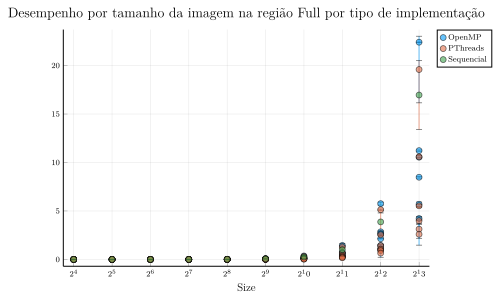

In [75]:
plot_results(omp_full.size, omp_full.mean_duration, "OpenMP", omp_full.ci_duration,
    y2 = pth_full.mean_duration, series_label2 = "PThreads", yerror2 = pth_full.ci_duration,
    x3 = seq_full.size, y3 = seq_full.mean_duration, series_label3 = "Sequencial", yerror3 = seq_full.ci_duration,
    title = "Desempenho por tamanho da imagem na região Full por tipo de implementação",
    xaxis = "Size", max_thread_power = 13)

In [86]:
seq_elephant

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,0,16,0.0004366,0.00020518
2,0,32,0.0018345,0.0017706
3,0,64,0.0062625,0.00352806
4,0,128,0.0244418,0.0150563
5,0,256,0.0888689,0.0692212
6,0,512,0.343512,0.275899
7,0,1024,1.05258,0.404474
8,0,2048,4.36668,1.1568
9,0,4096,17.0441,3.60816


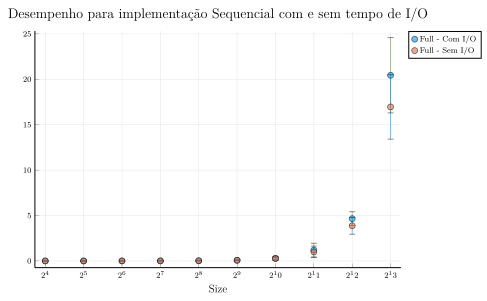

In [79]:
plot_results(seq_full.size, seq_full.mean_io_alocation, "Full - Com I/O", seq_full.ci_io_alocation,
    y2 = seq_full.mean_duration, series_label2 = "Full - Sem I/O", yerror2 = seq_full.ci_duration,
#   y3 = seq_seahorse.mean_io_alocation, series_label3 = "Seahorse - Com I/O", yerror3 = seq_seahorse.ci_io_alocation,
#   y4 = seq_seahorse.mean_duration, series_label4 = "Seahorse - Sem I/O", yerror4 = seq_seahorse.ci_duration,
#   y3 = seq_triplespiral.mean_io_alocation, series_label3 = "TripleSpiral", yerror3 = seq_triplespiral.ci_io_alocation,
#    y4 = seq_elephant.mean_io_alocation, series_label4 = "Elephant", yerror4 = seq_elephant.ci_io_alocation,
    title = "Desempenho para implementação Sequencial com e sem tempo de I/O",
    xaxis = "Size", max_thread_power = 13)

In [60]:
seq_full

,threads,size,mean_duration,mean_io_alocation,ci_duration,ci_io_alocation
,Int64,Int64,Float64,Float64,Float64,Float64
1,0,16,8.08e-5,0.0001729,3.28595e-5,7.39361e-5
2,0,32,0.0003396,0.0004958,0.000250409,0.0004053
3,0,64,0.0013337,0.0017034,0.00106752,0.00157017
4,0,128,0.0050639,0.0061506,0.00338823,0.00421371
5,0,256,0.0170587,0.0206839,0.00808679,0.0089236
6,0,512,0.0639297,0.0764949,0.0408877,0.0475074
7,0,1024,0.25328,0.304355,0.168291,0.199752
8,0,2048,0.9975,1.19646,0.638947,0.762267
9,0,4096,3.87142,4.653,0.925365,0.764569


### Conclusões

In [ ]:
plot_results(
    filter(row -> row[:size] == 16, omp_ful0l).threads,
    filter(row -> row[:size] == 16, omp_full).mean_duration, "Full", 
    filter(row -> row[:size] == 16, omp_full).ci_duration,
    y2 = filter(row -> row[:size] == 32, omp_full).mean_duration,
    series_label2 = "32", yerror2 = filter(row -> row[:size] == 32, omp_full).ci_duration)

In [ ]:
function fazgrafico(filename, label)
    
    plot_results(filename.threads, filename.mean_duration, label, filename.ci_duration)
end   

In [ ]:
fazgrafico(pth_full, "pth_full")

In [ ]:
fazgrafico(seq_full, "seq_full") #, filename2 = seq_seahorse, label2 = "seq_seahorse")

In [ ]:
seq_seahorse

In [ ]:
fazgrafico(omp_full, "omp_full")


In [ ]:
fazgrafico(omp_triplespiral, "omp_triplespiral")


In [ ]:
fazgrafico(omp_elephant, "omp_elephant")


In [ ]:
fazgrafico(omp_seahorse, "omp_seahorse")